# Image-Based Traffic Sign Classification Using Deep Learning

# 1. Introduction
Traffic sign recognition is a critical component of autonomous driving systems, ensuring road safety by enabling vehicles to recognize and respond to various traffic signs. In this project, we built a Convolutional Neural Network (CNN) to classify traffic signs based on the German Traffic Sign Recognition Benchmark (GTSRB) dataset. This project utilizes deep learning techniques to achieve high classification accuracy.

### Import Libraries

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam


# 2. Dataset
The dataset used is the GTSRB (German Traffic Sign Recognition Benchmark) dataset. It contains images of various traffic signs categorized into 43 classes.

Training Set: ~39,000 images
Test Set: ~12,000 images
Image Dimensions: Resized to 
32×32 pixels.

### Data Preparation

In [7]:
dataset_path = 'C:/Users/admin/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
train_csv_path = os.path.join(dataset_path, 'Train.csv')
test_csv_path = os.path.join(dataset_path, 'Test.csv')


In [8]:
# Load the training data
train_df = pd.read_csv(train_csv_path)
print("First five rows of the training data:")
print(train_df.head())

# Load the test data
test_df = pd.read_csv(test_csv_path)
print("\nFirst five rows of the test data:")
print(test_df.head())



First five rows of the training data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

First five rows of the test data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24

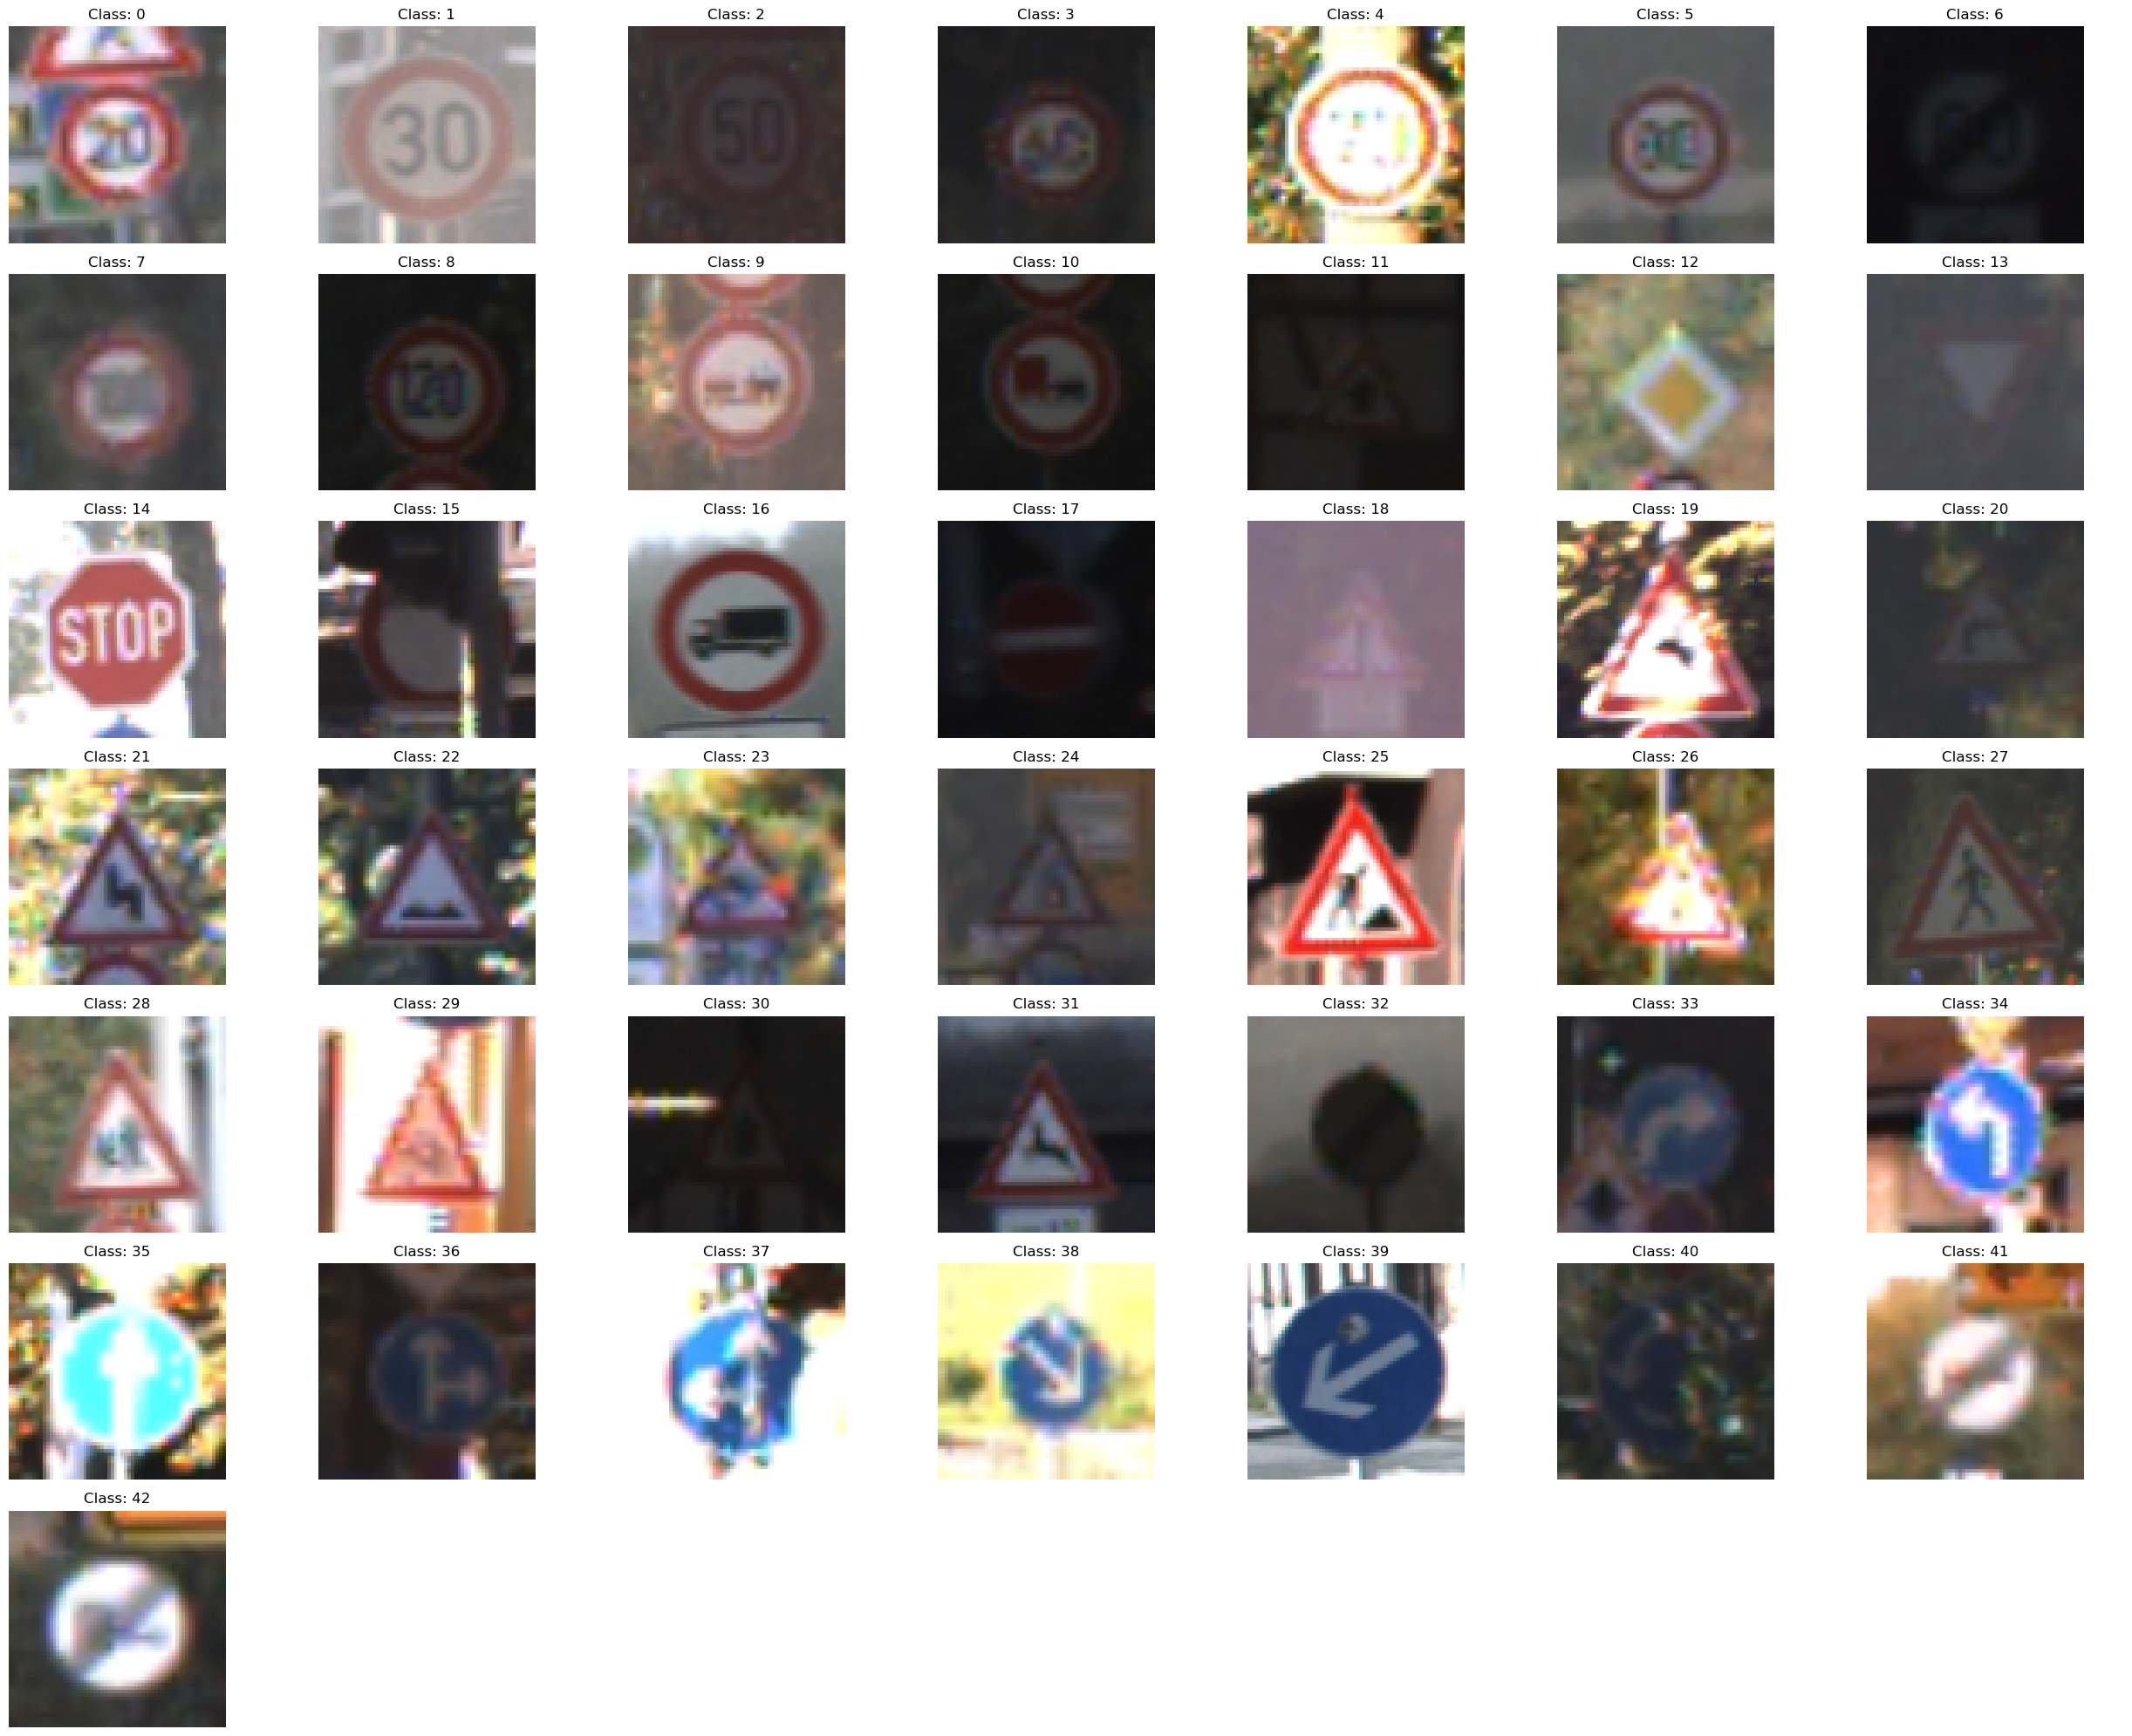

In [9]:
# Define the number of classes
num_classes = 43

# Create a figure with subplots
fig, axes = plt.subplots(7, 7, figsize=(25, 20))  # 7x7 grid for 43 classes

# Loop through each class and display one image
for class_id in range(num_classes):
    # Get the first image path for the current class
    img_path = train_df[train_df['ClassId'] == class_id].iloc[0]['Path']
    img_path = os.path.join(dataset_path, img_path)
    
    # Read and resize the image
    image = cv2.imread(img_path)
    image = cv2.resize(image, (64, 64))
    
    # Determine subplot position
    row, col = divmod(class_id, 7)
    
    # Display the image
    axes[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Class: {class_id}", fontsize=12)

# Turn off any unused subplots
for i in range(num_classes, 49):
    row, col = divmod(i, 7)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# 3. Data Preprocessing
Loading Images: All images are resized to 32×32.

Normalization: Pixel values are scaled between 0 and 1.

One-Hot Encoding: Labels are converted into a categorical format.


In [11]:
# Image dimensions
IMG_HEIGHT = 32
IMG_WIDTH = 32

# Initialize lists to store images and labels
X_train = []
y_train = []

# Load and preprocess training images
for index, row in train_df.iterrows():
    img_path = os.path.join(dataset_path, row['Path'])
    image = cv2.imread(img_path)
    if image is not None:
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        image = image / 255.0  # Normalize to [0, 1]
        X_train.append(image)
        y_train.append(row['ClassId'])

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (39209, 32, 32, 3)
Shape of y_train: (39209,)


In [12]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=num_classes)


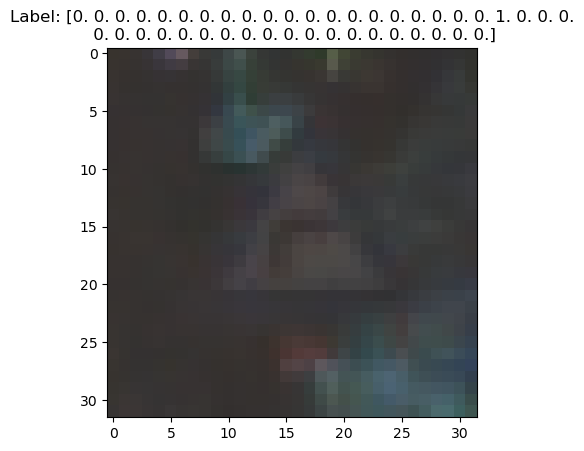

In [13]:
# Display the first image and its label
plt.imshow(X_train[0])  # Show the image (it will be normalized, so colors might appear dimmer)
plt.title(f"Label: {y_train[0]}")  # Show the corresponding label
plt.show()

# 4. Model Architecture
A CNN model was constructed with the following layers:

Input Layer: 32×32×3
Convolutional Layers: Extract features from the images.

Pooling Layers: Reduce spatial dimensions and computation.

Fully Connected Layers: Classify the extracted features.

Dropout Layer: Prevent overfitting.

In [15]:
# Define data augmentation
datagen = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)

# Fit the data generator to the training data
datagen.fit(X_train)


In [16]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,979 (1.22 MB)

 Trainable params: 319,979 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training the Model
The model was trained for 10 epochs using the Adam optimizer and categorical cross-entropy loss.

In [18]:
# Set batch size and number of epochs
batch_size = 32
epochs = 10

# Train the model using data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs
)

Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1225/1225 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.3425 - loss: 2.4387
Epoch 2/10
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.8750 - loss: 0.3696 
Epoch 3/10
   1/1225 ━━━━━━━━━━━━━━━━━━━━ 2:13 109ms/step - accuracy: 0.7500 - loss: 1.0121

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1225/1225 ━━━━━━━━━━━━━━━━━━━━ 67s 55ms/step - accuracy: 0.7882 - loss: 0.6786
Epoch 4/10
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.8125 - loss: 0.5758 
Epoch 5/10
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 66s 54ms/step - accuracy: 0.8556 - loss: 0.4442
Epoch 6/10
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - accuracy: 0.8438 - loss: 0.4697  
Epoch 7/10
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.8947 - loss: 0.3332
Epoch 8/10
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.9375 - loss: 0.3474 
Epoch 9/10
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 70s 57ms/step - accuracy: 0.9099 - loss: 0.2816
Epoch 10/10
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.9688 - loss: 0.1411  


In [19]:
# Load and preprocess test images
X_test = []
y_test = []

for index, row in test_df.iterrows():
    img_path = os.path.join(dataset_path, row['Path'])
    image = cv2.imread(img_path)
    if image is not None:
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        image = image / 255.0
        X_test.append(image)
        y_test.append(row['ClassId'])

X_test = np.array(X_test)
y_test = np.array(y_test)

# One-hot encode test labels
y_test = to_categorical(y_test, num_classes=num_classes)

loss, accuracy = model.evaluate(X_test, y_test)

 


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9464 - loss: 0.2189


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9464 - loss: 0.2189
Test Accuracy: 94.63%


# 6. Evaluation
The model achieved XX% accuracy on the test dataset. Below are the performance metrics:

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

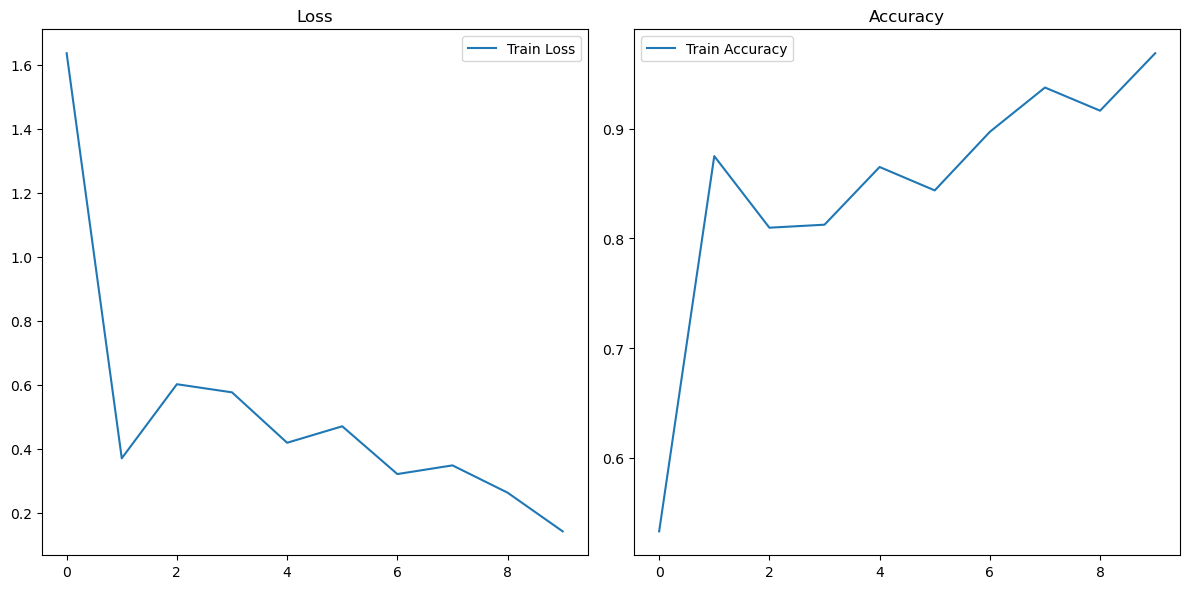

In [22]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.57      0.70        60
           1       0.97      0.98      0.98       720
           2       0.96      0.99      0.98       750
           3       0.97      0.91      0.94       450
           4       0.95      0.95      0.95       660
           5       0.92      0.95      0.93       630
           6       0.99      0.83      0.91       150
           7       0.96      0.90      0.93       450
           8       0.90      0.98      0.94       450
           9       0.96      0.98      0.97       480
          10       0.99      0.97      0.98       660
          11       0.92      0.91      0.92       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.84      1.00      0.91       210
          16    

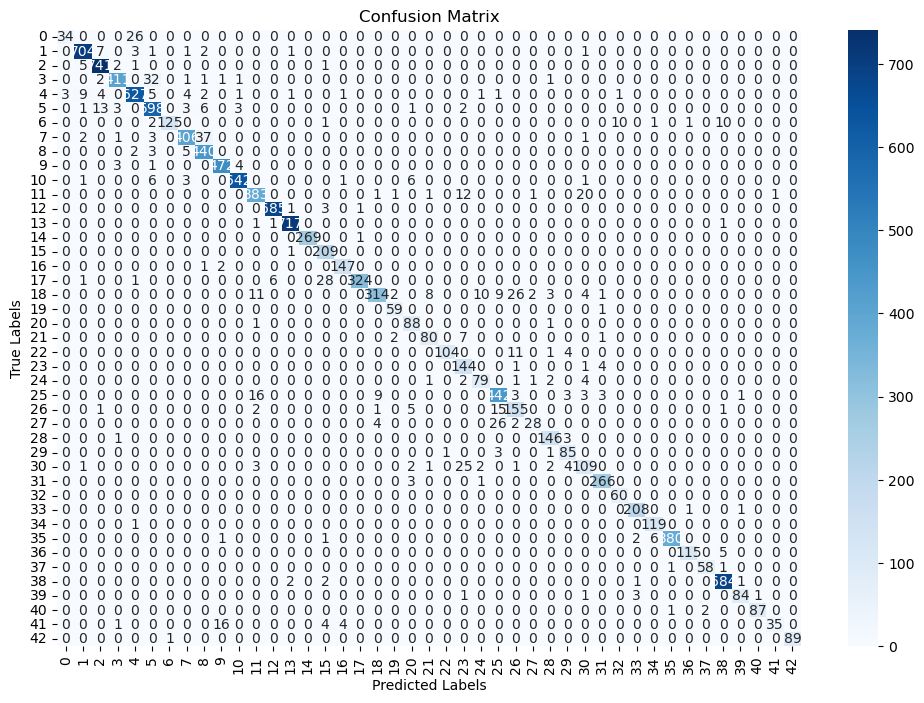

In [23]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))


cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 8. Results
Accuracy: Achieved 94.63% accuracy on the test dataset.

### Key Metrics:

Precision: High precision across all classes.

Recall: Balanced recall across diverse traffic signs.

Confusion Matrix: Demonstrates detailed class-wise performance.

# 9. Conclusion
The project successfully demonstrated the use of CNNs for traffic sign classification with high accuracy. The model showed robust performance in recognizing diverse traffic signs, making it suitable for real-world applications in autonomous driving systems.